## Mounting Environemnt If On Colab

In [54]:
# # If you are working in Colab, then consider mounting your assignment folder to your drive
# from google.colab import drive
# drive.mount('/content/drive')

# # # Direct to your assignment folder.
# %cd /content/drive/MyDrive/ColabNotebooks/Semester_Project_II/zebra_SAM

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/ColabNotebooks/Semester_Project_II/zebra_SAM


## Installing Environment Requirements. Only Do Once If Project Is Local

In [55]:
!sudo apt install imagemagick

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
imagemagick is already the newest version (8:6.9.11.60+dfsg-1.3ubuntu0.22.04.3).
0 upgraded, 0 newly installed, 0 to remove and 43 not upgraded.


In [56]:
!apt-get install -y libmagickwand-dev

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libmagickwand-dev is already the newest version (8:6.9.11.60+dfsg-1.3ubuntu0.22.04.3).
0 upgraded, 0 newly installed, 0 to remove and 43 not upgraded.


In [57]:

!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [58]:
!pip install -r requirements.txt

  Cloning https://github.com/mhe/pynrrd.git to /tmp/pip-req-build-n_143rpy
  Running command git clone --filter=blob:none --quiet https://github.com/mhe/pynrrd.git /tmp/pip-req-build-n_143rpy
  Resolved https://github.com/mhe/pynrrd.git to commit d7f1d0ced4aadb01cc160b16e2763d27e7e3d386
  Preparing metadata (setup.py) ... done


## Imports

In [59]:

%load_ext autoreload
%autoreload 2

import random
import os
import glob
import time
import warnings
import io
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
# import opendatasets as od
import datasets as dts

from PIL import Image
from IPython.display import clear_output
from tqdm.notebook import tqdm
from typing import Dict, List, Tuple
from statistics import mean


import torch
import monai
import cv2
import torchvision
import torch.optim.lr_scheduler as lr_scheduler
from torch import nn
from torch.utils.data import DataLoader
from torch.optim import Adam
from torchvision import transforms
from monai.transforms import Compose, NormalizeIntensityd
from monai.metrics import compute_iou
from sklearn.model_selection import train_test_split

from transformers import SamProcessor
from transformers import SamModel

# Custom .py files
# from generate_data_folder import generate_data_folder
from generate_data_folder import adjust_jpg

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# CONFIGURATION

In [61]:
plt.style.use("dark_background")
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")

In [62]:
class CFG:
    # define paths
    DATASET_PATH = "multi_data/"
    TRAIN_PATH = "multi_data/"

    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    # DEVICE = 'cpu'
    TRAIN_BATCH_SIZE = 2
    TEST_BATCH_SIZE = 1
    LEARNING_RATE = 1e-3
    WEIGHT_DECAY = 0
    EPOCH = 30
    NUM_SEGMENTS = 0

print(CFG.DEVICE)

cuda


# DATA PREPARATION

## Adapte Raw Zebrafish Data. Do NOT Execute If Data Already Available

In [63]:
# # Custom .py files
# from generate_data_folder import generate_data_folder
# from tiff_to_jpgs import adjust_jpg

# rawData_path = "raw_data/zebrafish_3"
# tifPath = rawData_path + "/t0020_Channel 3.tif"
# nrrdPath = rawData_path + "/Segmentation_20.seg.nrrd"

# # Create data folder for training
# generate_data_folder(tif_file_path=tifPath, nrrd_file_path=nrrdPath, zebrafish_number=3)

## Create dataframes containing the input image paths

In [ ]:
dataset_images = glob.glob(f"{CFG.TRAIN_PATH}**/*.tif")
dataset_images

['multi_data/zebrafish_2/zebrafish_2_frame_5.tif',
 'multi_data/zebrafish_2/zebrafish_2_frame_6.tif',
 'multi_data/zebrafish_2/zebrafish_2_frame_12.tif',
 'multi_data/zebrafish_2/zebrafish_2_frame_2.tif',
 'multi_data/zebrafish_2/zebrafish_2_frame_3.tif',
 'multi_data/zebrafish_2/zebrafish_2_frame_8.tif',
 'multi_data/zebrafish_2/zebrafish_2_frame_4.tif',
 'multi_data/zebrafish_2/zebrafish_2_frame_9.tif',
 'multi_data/zebrafish_2/zebrafish_2_frame_10.tif',
 'multi_data/zebrafish_2/zebrafish_2_frame_11.tif',
 'multi_data/zebrafish_2/zebrafish_2_frame_7.tif',
 'multi_data/zebrafish_2/zebrafish_2_frame_1.tif',
 'multi_data/zebrafish_2/zebrafish_2_frame_22.tif',
 'multi_data/zebrafish_2/zebrafish_2_frame_19.tif',
 'multi_data/zebrafish_2/zebrafish_2_frame_17.tif',
 'multi_data/zebrafish_2/zebrafish_2_frame_21.tif',
 'multi_data/zebrafish_2/zebrafish_2_frame_16.tif',
 'multi_data/zebrafish_2/zebrafish_2_frame_15.tif',
 'multi_data/zebrafish_2/zebrafish_2_frame_20.tif',
 'multi_data/zebrafis

In [65]:
def get_zebrafish_id(image_paths):
    return [(_.split('/')[-2:][0]) for _ in image_paths]

def get_sample_number(image_paths):
    sample_numbers = []
    is_mask = []

    for path in image_paths:
        path_list = path.split('/')[-2:][1].split('_')

        sample_numbers.append(int(path_list[-1].replace('.tif', '')))
        is_mask.append(0)

    return sample_numbers

def build_df(image_paths):
    sample_numbers = get_sample_number(image_paths)
    # create dataframe
    df = pd.DataFrame({
        'id'        : sample_numbers,
        'zebrafish'   : get_zebrafish_id(image_paths),
        'image_path': image_paths,
    })

    return df

In [66]:
df_images = (
    build_df(dataset_images)
    .sort_values(by=['id', 'zebrafish', 'image_path'])
    .reset_index(drop=True)
)

df_images['frame'] = df_images['image_path'].apply(lambda x: "frame_{}".format(re.search(r'frame_(\d+)', x).group(1)))


df_images

,id,zebrafish,image_path,frame
0,1,zebrafish_1,multi_data/zebrafish_1/zebrafish_1_frame_1.tif,frame_1
1,1,zebrafish_2,multi_data/zebrafish_2/zebrafish_2_frame_1.tif,frame_1
2,1,zebrafish_3,multi_data/zebrafish_3/zebrafish_3_frame_1.tif,frame_1
3,2,zebrafish_1,multi_data/zebrafish_1/zebrafish_1_frame_2.tif,frame_2
4,2,zebrafish_2,multi_data/zebrafish_2/zebrafish_2_frame_2.tif,frame_2
...,...,...,...,...
400,134,zebrafish_2,multi_data/zebrafish_2/zebrafish_2_frame_134.tif,frame_134
401,134,zebrafish_3,multi_data/zebrafish_3/zebrafish_3_frame_134.tif,frame_134
402,135,zebrafish_1,multi_data/zebrafish_1/zebrafish_1_frame_135.tif,frame_135
403,135,zebrafish_2,multi_data/zebrafish_2/zebrafish_2_frame_135.tif,frame_135


## Create dataframes containing the output mask paths (each value is a list of paths, for each folder)

In [67]:
root_dir = CFG.DATASET_PATH

# Initialize an empty list to store the data
data = []

# Traverse through the directory structure
for zebrafish in os.listdir(root_dir):
    zebrafish_dir = os.path.join(root_dir, zebrafish)
    if os.path.isdir(zebrafish_dir):
        masks_dir = os.path.join(zebrafish_dir, "masks")
        if os.path.isdir(masks_dir):
            for frame in os.listdir(masks_dir):
                frame_dir = os.path.join(masks_dir, frame)
                if os.path.isdir(frame_dir):
                    mask_files = [
                        os.path.normpath(os.path.join(frame_dir, mask)).replace('/', "/")
                        for mask in os.listdir(frame_dir)
                        if mask.endswith(".tif")
                    ]
                    data.append([zebrafish, frame, mask_files])

# Create a pandas DataFrame
df_masks = pd.DataFrame(data, columns=["zebrafish", "frame", "mask_path"])

# Display the DataFrame
df_masks

,zebrafish,frame,mask_path
0,zebrafish_2,frame_100,[multi_data/zebrafish_2/masks/frame_100/zebraf...
1,zebrafish_2,frame_1,[multi_data/zebrafish_2/masks/frame_1/zebrafis...
2,zebrafish_2,frame_102,[multi_data/zebrafish_2/masks/frame_102/zebraf...
3,zebrafish_2,frame_103,[multi_data/zebrafish_2/masks/frame_103/zebraf...
4,zebrafish_2,frame_107,[multi_data/zebrafish_2/masks/frame_107/zebraf...
...,...,...,...
400,zebrafish_3,frame_88,[multi_data/zebrafish_3/masks/frame_88/zebrafi...
401,zebrafish_3,frame_85,[multi_data/zebrafish_3/masks/frame_85/zebrafi...
402,zebrafish_3,frame_90,[multi_data/zebrafish_3/masks/frame_90/zebrafi...
403,zebrafish_3,frame_91,[multi_data/zebrafish_3/masks/frame_91/zebrafi...


In [68]:
CFG.NUM_SEGMENTS = len(df_masks['mask_path'].iloc[0])
CFG.NUM_SEGMENTS

11

### Combined df

In [69]:
dataset_df = pd.merge(df_images, df_masks, on=["zebrafish", "frame"])
dataset_df

,id,zebrafish,image_path,frame,mask_path
0,1,zebrafish_1,multi_data/zebrafish_1/zebrafish_1_frame_1.tif,frame_1,[multi_data/zebrafish_1/masks/frame_1/zebrafis...
1,1,zebrafish_2,multi_data/zebrafish_2/zebrafish_2_frame_1.tif,frame_1,[multi_data/zebrafish_2/masks/frame_1/zebrafis...
2,1,zebrafish_3,multi_data/zebrafish_3/zebrafish_3_frame_1.tif,frame_1,[multi_data/zebrafish_3/masks/frame_1/zebrafis...
3,2,zebrafish_1,multi_data/zebrafish_1/zebrafish_1_frame_2.tif,frame_2,[multi_data/zebrafish_1/masks/frame_2/zebrafis...
4,2,zebrafish_2,multi_data/zebrafish_2/zebrafish_2_frame_2.tif,frame_2,[multi_data/zebrafish_2/masks/frame_2/zebrafis...
...,...,...,...,...,...
400,134,zebrafish_2,multi_data/zebrafish_2/zebrafish_2_frame_134.tif,frame_134,[multi_data/zebrafish_2/masks/frame_134/zebraf...
401,134,zebrafish_3,multi_data/zebrafish_3/zebrafish_3_frame_134.tif,frame_134,[multi_data/zebrafish_3/masks/frame_134/zebraf...
402,135,zebrafish_1,multi_data/zebrafish_1/zebrafish_1_frame_135.tif,frame_135,[multi_data/zebrafish_1/masks/frame_135/zebraf...
403,135,zebrafish_2,multi_data/zebrafish_2/zebrafish_2_frame_135.tif,frame_135,[multi_data/zebrafish_2/masks/frame_135/zebraf...


In [72]:
def _load(image_path, as_tensor=True):
    image = Image.open(image_path)
    return np.array(image).astype(np.float32) / 255.

def generate_label(mask_path, load_fn):
    mask = load_fn(mask_path)
    if mask.max() > 0:
        return 1 # Brain Tumor Present
    return 0 # Normal

### Splitting the Data! Test Size = 25% Because we Have 3 scans for training and 1 for testing

In [95]:
image_train, image_test, mask_train, mask_test = train_test_split(
dataset_df['image_path'], dataset_df['mask_path'], test_size = 0.25, shuffle = False)

In [96]:

train_df = pd.concat([image_train, mask_train], axis=1).reset_index(drop=True)
train_dataset = dts.Dataset.from_pandas(train_df)

In [97]:
train_df['mask_path'].iloc[0]

['multi_data/zebrafish_1/masks/frame_1/zebrafish_1_frame_1_segment_4_mask.tif',
 'multi_data/zebrafish_1/masks/frame_1/zebrafish_1_frame_1_segment_5_mask.tif',
 'multi_data/zebrafish_1/masks/frame_1/zebrafish_1_frame_1_segment_1_mask.tif',
 'multi_data/zebrafish_1/masks/frame_1/zebrafish_1_frame_1_segment_3_mask.tif',
 'multi_data/zebrafish_1/masks/frame_1/zebrafish_1_frame_1_segment_6_mask.tif',
 'multi_data/zebrafish_1/masks/frame_1/zebrafish_1_frame_1_segment_2_mask.tif',
 'multi_data/zebrafish_1/masks/frame_1/zebrafish_1_frame_1_segment_8_mask.tif',
 'multi_data/zebrafish_1/masks/frame_1/zebrafish_1_frame_1_segment_9_mask.tif',
 'multi_data/zebrafish_1/masks/frame_1/zebrafish_1_frame_1_segment_10_mask.tif',
 'multi_data/zebrafish_1/masks/frame_1/zebrafish_1_frame_1_segment_7_mask.tif',
 'multi_data/zebrafish_1/masks/frame_1/zebrafish_1_frame_1_segment_11_mask.tif']

In [98]:
train_df.head()

,image_path,mask_path
0,multi_data/zebrafish_1/zebrafish_1_frame_1.tif,[multi_data/zebrafish_1/masks/frame_1/zebrafis...
1,multi_data/zebrafish_2/zebrafish_2_frame_1.tif,[multi_data/zebrafish_2/masks/frame_1/zebrafis...
2,multi_data/zebrafish_3/zebrafish_3_frame_1.tif,[multi_data/zebrafish_3/masks/frame_1/zebrafis...
3,multi_data/zebrafish_1/zebrafish_1_frame_2.tif,[multi_data/zebrafish_1/masks/frame_2/zebrafis...
4,multi_data/zebrafish_2/zebrafish_2_frame_2.tif,[multi_data/zebrafish_2/masks/frame_2/zebrafis...


In [100]:
test_df = pd.concat([image_test, mask_test], axis=1).reset_index(drop=True)
test_dataset = dts.Dataset.from_pandas(test_df)

In [101]:
test_df.head()

,image_path,mask_path
0,multi_data/zebrafish_2/zebrafish_2_frame_91.tif,[multi_data/zebrafish_2/masks/frame_91/zebrafi...
1,multi_data/zebrafish_3/zebrafish_3_frame_91.tif,[multi_data/zebrafish_3/masks/frame_91/zebrafi...
2,multi_data/zebrafish_1/zebrafish_1_frame_92.tif,[multi_data/zebrafish_1/masks/frame_92/zebrafi...
3,multi_data/zebrafish_2/zebrafish_2_frame_92.tif,[multi_data/zebrafish_2/masks/frame_92/zebrafi...
4,multi_data/zebrafish_3/zebrafish_3_frame_92.tif,[multi_data/zebrafish_3/masks/frame_92/zebrafi...


### Some Helper Functions for Image Formatting Visualization

In [103]:
def load_and_convert_mask(mask_path):
    try:
        if os.path.exists(mask_path):
            mask = Image.open(mask_path).convert('L')
            return mask
        else:
            print(f"File not found: {mask_path}")
            return None
    except Exception as e:
        print(f"Error loading image {mask_path}: {e}")
        return None

def load_and_convert_image(image_path):
    try:
        if os.path.exists(image_path):
            with open(image_path, 'rb') as f:
                image = io.BytesIO(f.read())  # Read image data as bytes
            image = (Image.fromarray(adjust_jpg(np.array(Image.open(image))))).convert('RGB')  # Convert bytes to numpy array
            return image
        else:
            print(f"File not found: {image_path}")
            return None
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        return None

### Bounding Box Helper Function to Create Prompts for each Input

In [104]:
def get_bounding_box(ground_truth_map):
    '''
    This function creates varying bounding box coordinates based on the segmentation contours as prompt for the SAM model
    The padding is random int values between 5 and 20 pixels
    '''

    if len(np.unique(ground_truth_map)) > 1:

        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)

        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(5, 20))
        x_max = min(W, x_max + np.random.randint(5, 20))
        y_min = max(0, y_min - np.random.randint(5, 20))
        y_max = min(H, y_max + np.random.randint(5, 20))

        bbox = [x_min, y_min, x_max, y_max]
        # bbox = [x_max, y_max]

        return bbox
    else:
        return [0, 0, 2034, 2034]
        # return [128, 128]

In [107]:
train_dataset

Dataset({
    features: ['image_path', 'mask_path'],
    num_rows: 271
})

### Create Sam Class for path conversion and Image visualization

In [112]:
class SAMDataset(torch.utils.data.Dataset):
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor
    #self.transforms = transforms = Compose([NormalizeIntensityd(divisor=255, keys=['mask'])])

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    ground_truth_masks = item['mask_path']

    # ground_truth_mask = item["mask"]

    # get general bounding  box prompt
    prompts = []
    masks_tensor = []
    for path in ground_truth_masks :
      masks_tensor.append(torch.tensor(np.array(load_and_convert_mask(path))))

    masks_tensor = torch.stack(masks_tensor)
    masks_tensor = torch.where(masks_tensor != 0.0,
                             torch.tensor(1.0),
                             torch.tensor(0.0))
    general_prompt = get_bounding_box(torch.sum(masks_tensor, dim = 0).cpu().numpy())

    # prepare image and prompt for the model

    # print(f"image : {np.array(image)}")
    inputs = self.processor(load_and_convert_image(item["image_path"]),
                            input_boxes=[[general_prompt]], return_tensors="pt").to(CFG.DEVICE)

    # remove batch dimension which the processor adds by default
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # add ground truth segmentation
    inputs["ground_truth_masks"] = masks_tensor

    return inputs

In [113]:
processor_custom = SamProcessor.from_pretrained("facebook/sam-vit-base", do_normalize=False, device = CFG.DEVICE)

In [114]:
train_sam_ds = SAMDataset(dataset=train_dataset, processor=processor_custom)

In [115]:
exmpl = train_sam_ds[0]
for k,v in exmpl.items():
  print(k,v.shape)

pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_boxes torch.Size([1, 4])
ground_truth_masks torch.Size([11, 2304, 2304])


In [117]:
train_dataloader = DataLoader(train_sam_ds, batch_size=CFG.TRAIN_BATCH_SIZE, shuffle=False)

In [118]:
# create test dataloader
test_sam_ds = SAMDataset(test_dataset, processor=processor_custom)
test_dataloader = DataLoader(test_sam_ds, batch_size=CFG.TEST_BATCH_SIZE, shuffle=False)

In [119]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

pixel_values torch.Size([2, 3, 1024, 1024])
original_sizes torch.Size([2, 2])
reshaped_input_sizes torch.Size([2, 2])
input_boxes torch.Size([2, 1, 4])
ground_truth_masks torch.Size([2, 11, 2304, 2304])


# Modeling

In [120]:
class MultiSAM(nn.Module):
    def __init__(self, num_classes):
        super(MultiSAM, self).__init__()

        self.sam = SamModel.from_pretrained("facebook/sam-vit-base")
        self.conv_layer = nn.Conv2d(in_channels=1, out_channels=num_classes, kernel_size=1)  # Adjust parameters as needed

    def forward(self, x):

        # Assuming x is your image data that needs to be compatible with your conv layer
        x = self.sam(pixel_values = x["pixel_values"].to(CFG.DEVICE),
                     input_boxes = x["input_boxes"].to(CFG.DEVICE),
                     multimask_output=False).pred_masks.squeeze(1).to(CFG.DEVICE)

        x = self.conv_layer(x)

        return x

### Deactivate prompt encoder and image encoder parameters from being finetuned

In [121]:
model = MultiSAM(CFG.NUM_SEGMENTS).to(CFG.DEVICE)

for name, param in model.named_parameters():
    if name.startswith("transformer_model.vision_encoder") or name.startswith("transformer_model.prompt_encoder"):
        param.requires_grad_(False)

### Activate Necessary Parameters

In [123]:
# Set proper parameters to be updated during training

parameters_to_optimize = [
    param for name, param in model.named_parameters()
    if 'mask_decoder' in name or 'conv_layer' in name
]

# Create the optimizer with these parameters
optimizer = Adam(parameters_to_optimize, lr=CFG.LEARNING_RATE, weight_decay=CFG.WEIGHT_DECAY)
seg_loss = monai.losses.FocalLoss(reduction='mean')

In [125]:
def interpolate(batch_tensor, new_size):
    # Get the original dimensions
    M, S, D1, _ = batch_tensor.size()

    # Reshape to [M*S, 1, D1, D1] for interpolation
    reshaped_tensor = batch_tensor.view(-1, 1, D1, D1)

    # Resize each mask to the new size
    resized_tensor = F.interpolate(reshaped_tensor, size=new_size, mode='nearest')

    # Reshape back to original shape [M, S, D2, D2]
    new_shape = (M, S) + new_size
    interpolated_batch = resized_tensor.view(*new_shape)

    return interpolated_batch

## TRAINING

In [ ]:
num_epochs = CFG.EPOCH

device = CFG.DEVICE
model.to(device)

model.train()

epoch_losses = []
epoch_ious = []
test_losses = []
test_ious = []

colors = (np.arange(1, CFG.NUM_SEGMENTS+1))*(255.0/CFG.NUM_SEGMENTS)

for epoch in range(num_epochs):
    print(f'EPOCH: {epoch+1}')

    batch_losses = []
    batch_ious = []


    #########################################
    ############## Train Loop ###############
    #########################################
    for i, batch in enumerate(tqdm(train_dataloader)):

      batch_size = batch["ground_truth_masks"].shape[0]
      new_size = (batch["ground_truth_masks"].shape[-1], batch["ground_truth_masks"].shape[-1])

      # forward pass
      predicted_masks = model(batch)
      predicted_masks = interpolate(predicted_masks, new_size)

      ground_truth_masks = batch["ground_truth_masks"].float().to(device)

      new_size = (ground_truth_masks.shape[-1], ground_truth_masks.shape[-1])

      sam_mask = torch.sigmoid(predicted_masks)
      sam_mask = torch.where(sam_mask > torch.tensor(0.5),
                             torch.tensor(1),
                             torch.tensor(0.0)).float()

      loss = 0.0
      iou = 0.0

      ### Comput individual losses over segment pairs ###

      # Iterate over batches
      for b in range(predicted_masks.shape[0]):
        # Iterate over segments/classes
        for s in range(predicted_masks.shape[1]):
            # current_loss = seg_loss(predicted_masks[b, s].unsqueeze(0),
            #                         ground_truth_masks[b, s].unsqueeze(0))
            current_iou = compute_iou(sam_mask[b, s].unsqueeze(0).unsqueeze(0),
                                      ground_truth_masks[b, s].unsqueeze(0).unsqueeze(0))
            # loss += current_loss
            iou += current_iou

      loss = seg_loss(predicted_masks, ground_truth_masks)

      iou /= (CFG.NUM_SEGMENTS*batch_size)

      # compute loss
      batch_losses.append(loss.item())

      if not(np.isnan(iou.item())) :
        batch_ious.append(iou.item())

      # backward pass (compute gradients of parameters w.r.t. loss)
      optimizer.zero_grad()
      loss.backward()

      # optimize
      optimizer.step()

      if torch.cuda.is_available():
        torch.cuda.empty_cache()

    mean_loss = np.nanmean(batch_losses)
    epoch_losses.append(mean_loss)

    if (len(batch_ious) >= 1) :
      mean_iou = np.nanmean(batch_ious)
    else :
      mean_iou = 0
    epoch_ious.append(mean_iou)

    #########################################
    ############## Test Loop ################
    #########################################
    batch_losses = []
    batch_ious = []

    model.eval()

    # Iteratire through test images
    with torch.no_grad():
        for batch in tqdm(test_dataloader):

            batch_size =  batch["ground_truth_masks"].shape[0]
            img_dim = batch["ground_truth_masks"].shape[-1]

            # forward pass
            predicted_masks = model(batch)

            ground_truth_masks = batch["ground_truth_masks"].int().to(CFG.DEVICE)

            new_size = (ground_truth_masks.shape[-1], ground_truth_masks.shape[-1])
            predicted_masks = interpolate(predicted_masks, new_size)

            sam_mask = torch.sigmoid(predicted_masks)
            sam_mask = torch.where(sam_mask > torch.tensor(0.5),
                                  torch.tensor(1.0),
                                  torch.tensor(0.0)).float()

            overlapping_mask = torch.zeros(batch_size, img_dim, img_dim, device = CFG.DEVICE)
            adapted_preds = torch.zeros(batch_size, img_dim, img_dim, device = CFG.DEVICE)
            adapted_ground = torch.zeros(batch_size, img_dim, img_dim, device = CFG.DEVICE)

            loss = 0.0
            iou = 0.0

            # Iterate over batches
            for b in range(predicted_masks.shape[0]):
              # Iterate over segments/classes
              for s in range(predicted_masks.shape[1]):
                current_loss = seg_loss(predicted_masks[b, s].unsqueeze(0),
                                        ground_truth_masks[b, s].unsqueeze(0))

                loss += current_loss

                overlapping_mask += sam_mask[:, s, :, :]
                adapted_preds += sam_mask[:, s, :, :]*colors[s]
                adapted_ground += ground_truth_masks[:, s, :, :]*colors[s]/255.0

            overlapping_mask = 1 - (overlapping_mask > 1).int()

            adapted_preds = (adapted_preds*overlapping_mask).squeeze(0)
            adapted_ground = adapted_ground.squeeze(0)

            iou = compute_iou(adapted_preds.cpu(),
                              adapted_ground.cpu())


            sam_mask = adapted_preds

            if not(np.isnan(iou.item())) :
              batch_ious.append(iou.item())

            batch_losses.append(loss.item())

    mean_test_loss = np.nanmean(batch_losses)
    test_losses.append(mean_test_loss)
    print(f'Mean Test Focal loss: {mean_test_loss}')

    if (len(batch_ious) >= 1) :
      mean_test_iou = np.nanmean(batch_ious)
    else :
      mean_test_iou = np.nan
    test_ious.append(mean_test_iou)
    print(f'Mean Test IoU: {mean_test_iou}')

    #########################################
    ############## MODEL SAVING #############
    # Uncomment the following bloc of code
    # in order to save the model every 5 
    # epochs 
    #########################################
    #########################################

    # if (epoch//5 == 0) :
      # Specify the file path where you want to save the model parameters
      # checkpoint_path = f'models/medsam_10soms{epoch+1}.pth'

      # Save the parameters of the entire model
      # torch.save(model.state_dict(), checkpoint_path)

    model.train()



In [ ]:
plt.plot(np.arange(1,CFG.EPOCH+1), epoch_losses)
plt.xlabel('Epoch')
plt.ylabel('Train Loss')

Text(0, 0.5, 'Train IoU')

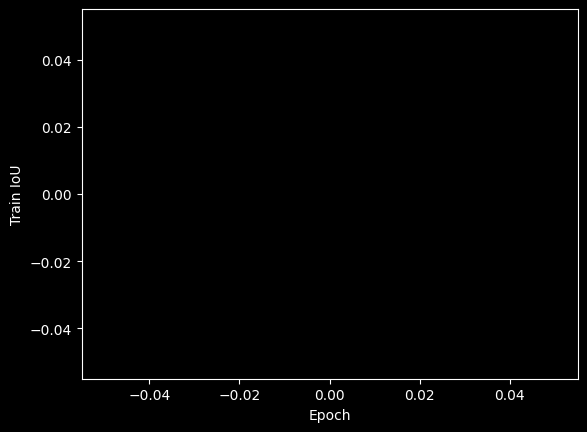

In [ ]:
plt.plot(np.arange(1,CFG.EPOCH+1), epoch_ious)
plt.xlabel('Epoch')
plt.ylabel('Train IoU')

Text(0, 0.5, 'Test Loss')

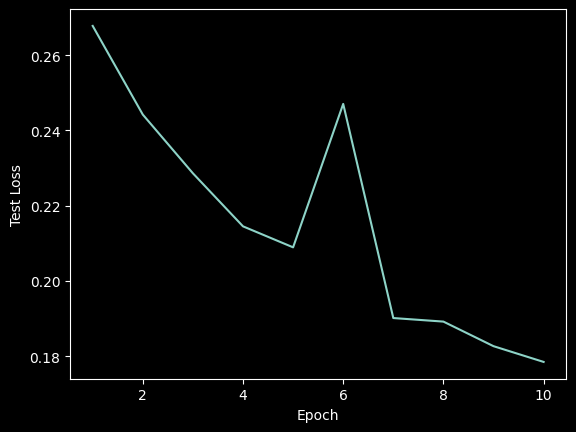

In [ ]:
plt.plot(np.arange(1,CFG.EPOCH+1), test_losses)
plt.xlabel('Epoch')
plt.ylabel('Test Loss')

Text(0, 0.5, 'Test IoU')

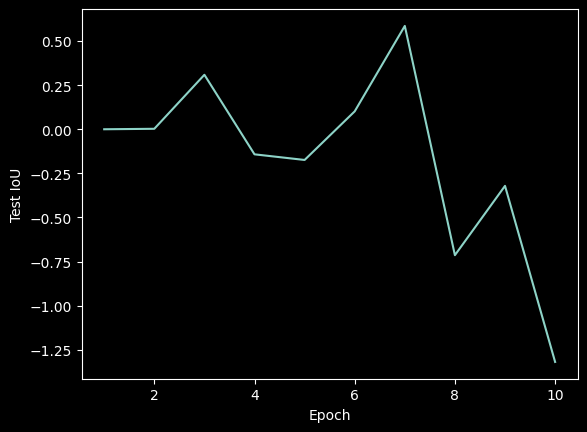

In [ ]:
plt.plot(np.arange(1,CFG.EPOCH+1), test_ious)
plt.xlabel('Epoch')
plt.ylabel('Test IoU')

## TESTING WITH VISUALIZATION

Load Pretrained model if necessary

In [ ]:
checkpoint_path = "example/path"
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint)

<All keys matched successfully>

In [ ]:
test_losses = []
test_ious = []
model.eval()

colors = (np.arange(1, CFG.NUM_SEGMENTS+1))*(255.0/CFG.NUM_SEGMENTS)
print(f"COLORS : {colors}")
# Iteratire through test images
with torch.no_grad():
  batch_ious = []
  batch_losses = []
  for batch in tqdm(test_dataloader):

      batch_size =  batch["ground_truth_masks"].shape[0]
      img_dim = batch["ground_truth_masks"].shape[-1]

      # forward pass
      predicted_masks = model(batch)

      ground_truth_masks = batch["ground_truth_masks"].int().to(CFG.DEVICE)

      new_size = (ground_truth_masks.shape[-1], ground_truth_masks.shape[-1])
      predicted_masks = interpolate(predicted_masks, new_size)

      sam_mask = torch.sigmoid(predicted_masks)
      sam_mask = torch.where(sam_mask > torch.tensor(0.5),
                            torch.tensor(1.0),
                            torch.tensor(0.0)).float()

      print(f"SAM VALS : {np.unique(sam_mask.cpu().numpy())}")

      overlapping_mask = torch.zeros(batch_size, img_dim, img_dim, device = CFG.DEVICE)
      adapted_preds = torch.zeros(batch_size, img_dim, img_dim, device = CFG.DEVICE)
      adapted_ground = torch.zeros(batch_size, img_dim, img_dim, device = CFG.DEVICE)

      loss = 0.0
      iou = 0.0

      # Iterate over batches
      for b in range(predicted_masks.shape[0]):
        # Iterate over segments/classes
        for s in range(predicted_masks.shape[1]):
          current_loss = seg_loss(predicted_masks[b, s].unsqueeze(0),
                                  ground_truth_masks[b, s].unsqueeze(0))

          loss += current_loss

          overlapping_mask += sam_mask[:, s, :, :]
          adapted_preds += sam_mask[:, s, :, :]*colors[s]/255.0
          adapted_ground += ground_truth_masks[:, s, :, :]*colors[s]/255.0

      overlapping_mask = 1 - (overlapping_mask > 1).int()

      loss /= (CFG.NUM_SEGMENTS*batch_size)

      # adapted_preds = (adapted_preds*overlapping_mask).squeeze(0)
      adapted_preds = (adapted_preds).squeeze(0)
      adapted_ground = adapted_ground.squeeze(0)

      iou = compute_iou(adapted_preds.cpu(),
                        adapted_ground.cpu())


      sam_mask = adapted_preds

      current_iou = 0.0

      if np.isnan(iou.item()) :
        current_iou = 0.0
      else :
        current_iou = iou.item()

      batch_ious.append(current_iou)
      batch_losses.append(loss.item())

      plt.figure(figsize=(12,4))
      plt.subplot(1,3,1)
      plt.imshow(batch["pixel_values"][0,1].cpu(), cmap='gray')
      plt.title('Zebrafish Scan')
      plt.axis('off')

      plt.subplot(1,3,2)
      plt.imshow(adapted_ground.cpu(), cmap='copper')
      plt.title('Actual Mask')
      plt.axis('off')

      plt.subplot(1,3,3)
      plt.imshow(sam_mask.cpu(), cmap='copper')
      plt.title('Predicted Mask')
      plt.axis('off')

      plt.tight_layout()
      plt.show()

mean_test_loss = mean(batch_losses)
test_losses.append(mean_test_loss)
print(f'Mean Test Focal loss: {mean_test_loss}')

mean_test_iou = mean(batch_ious)
test_ious.append(mean_test_iou)
print(f'Mean Test IoU: {mean_test_iou}')

Output hidden; open in https://colab.research.google.com to view.